# Random Forest Classification of Heart Disease

Data downloaded from the UCI Machine Learning Repository at https://archive.ics.uci.edu/ml/datasets/heart+Disease

Original data seen from Kaggle at https://www.kaggle.com/ronitf/heart-disease-uci. This data is edited and is incorrect, so is not used.

## Importing Packages

In [1]:
##Import packages

#Data Processing
import pandas as pd
import numpy as np

#Finding the data on our system
import pathlib

#Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

#Random Forest
from sklearn.ensemble import RandomForestClassifier

#Cross-validation
from sklearn.model_selection import GridSearchCV

#Splitting data into training and test
from sklearn.model_selection import train_test_split

#Metrics to evaluate
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Plotting library
import matplotlib.pyplot as plt

## Import Data

### Understanding the Dataset

When you collect your own data, you should know exactly what each of the variables represent, and how the variables are encoded. Unfortunately, when working with others' data, we don't start with a full understanding of the data. Not being able to understand the data makes it extremely difficult to gain insight from it. You should definitely document any data of your own, as you might have to come back to it later, or someone else might have to interpret it in the future.

As it turns out with the original dataset that was planned to be used in this example ([Kaggle Heart Disease UCI](https://www.kaggle.com/ronitf/heart-disease-uci)), it is also important to check the integrity of the dataset, especially if we plan to use the insights that we extract from the data. Resulting from investigation of the data, it seems that this source has edited data, and is misleading in various areas (for example, the indicator variable values for heart disease were swapped!). Therefore, we swap to using a correct version of the dataset, cited by multiple papers using this: [UCI Machine Learning Repository Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease). This illustrates just how important it is to be able to trust our datasets if we're planning to use them.

At the UCI Machine Learning Repository, there is an accurate description of every column, of which only 14 are used (we will keep with this convention and only use these columns). The description of these columns is given as follows, to help our understanding:


- age: age in years
- sex: sex (1 = male; 0 = female)
- cp: chest pain type
1. Value 1: typical angina
2. Value 2: atypical angina
3. Value 3: non-anginal pain
4. Value 4: asymptomatic
- trestbps: resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholestoral in mg/dl
- fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg: resting electrocardiographic results
0. Value 0: normal
1. Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
2. Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach: maximum heart rate achieved
- exang: exercise induced angina (1 = yes; 0 = no)
- oldpeak = ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
1. Value 1: upsloping
2. Value 2: flat
3. Value 3: downsloping
- ca: number of major vessels (0-3) colored by flourosopy
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
- num: diagnosis of heart disease (angiographic disease status)
0. Value 0: < 50% diameter narrowing (No disease)
1. Value 1-4: > 50% diameter narrowing (Disease)

The "num" variable is used as our target value, and as described in the description of the dataset, non-zero values here indicate disease. Therefore, we can later transform our dataset to have either a 0, or a 1 for any disease.

### Importing the Data from the CSV File

In [2]:
##Import data from another directory

#Define the columns as described
cols = [
    "age",
    "sex",
    "cp",
    "trestbps",
    "chol",
    "fbs",
    "restecg",
    "thalach",
    "exang",
    "oldpeak",
    "slope",
    "ca",
    "thal",
    "num"
]


#Find the file from a local directiory
p = str(pathlib.Path().resolve()).replace("\\Notebooks\\Classification Methods", "")
p += ("\\Data\\Raw\\Heart_Disease_UCI.csv")
p = pathlib.Path(p).resolve()

#Read into a pandas dataframe
df = pd.read_csv(p, names=cols)

#Preview the dataset
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


### Basic Data Exploration

In [3]:
#Display basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


In [4]:
#Transform the target variable "num" into an indicator variable
df["num"] = [0 if i == 0 else 1 for i in df["num"]]

Notice that we have a few weird values in the dataset, such as this one. We can't use these datapoints for our analysis, and there are only a couple of them, so we will drop these rows. From our call of `df.info()`, we can see that these are in the "ca" and "thal" columns (because the data-type is object, meaning anything can occupy the position, rather than float64, specifying a decimal number), so we remove rows containing non-numeric values in these columns.

In [5]:
#Show weird value
df["thal"][266]

'?'

In [6]:
#Remove non-numeric datapoints
df = df[pd.to_numeric(df["ca"], errors='coerce').notnull()]
df = df[pd.to_numeric(df["thal"], errors='coerce').notnull()]

#Change columns to numeric
df["ca"] = pd.to_numeric(df["ca"])
df["thal"] = pd.to_numeric(df["thal"])

#Show our summary again, to check if our conversion worked
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  num       297 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 34.8 KB


## Data Transformation

### One-Hot Encoding

The data that we have has several categorical variables, which, although represented numerically, do need to be encoded. These variables have more than 2 categories that datapoints are fit into (those with 2 categories are already effectively encoded), which includes:
- cp
- restecg
- slope
- thal
- ca

We one-hot encode these using a built-in Pandas function `pd.get_dummies()`. We don't yet add these variables back into the DataFrame because of the scaling step that we will perform later, that is not appropriate for categorical variables such as these. Later, we will reconstruct a full DataFrame, such that we can train our model.

In [7]:
#One-hot encoding
cp_dummies = pd.get_dummies(df["cp"], prefix="cp")
restecg_dummies = pd.get_dummies(df["restecg"], prefix="restecg")
slope_dummies = pd.get_dummies(df["slope"], prefix="slope")
thal_dummies = pd.get_dummies(df["thal"], prefix="thal")
ca_dummies = pd.get_dummies(df["ca"], prefix="ca")

#Drop the original variables from the DataFrame
df = df.drop(["cp", "restecg", "slope", "thal", "ca"], axis=1)
df

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,num
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,1
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0
...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,140.0,241.0,0.0,123.0,1.0,0.2,1
298,45.0,1.0,110.0,264.0,0.0,132.0,0.0,1.2,1
299,68.0,1.0,144.0,193.0,1.0,141.0,0.0,3.4,1
300,57.0,1.0,130.0,131.0,0.0,115.0,1.0,1.2,1


### Recombine Data

Here, we recombine the data back into a single DataFrame (exlcuding the target/dependent variable "num"), such that we can fit our model to it later.

Unfortunately, after performing opertaions on the separate DataFrames, the indexes become off, such that we have to reset these for the data to realign.

In [8]:
#Reset all indexes
df = df.reset_index()
cp_dummies = cp_dummies.reset_index()
restecg_dummies = restecg_dummies.reset_index()
slope_dummies = slope_dummies.reset_index()
thal_dummies = thal_dummies.reset_index()
ca_dummies = ca_dummies.reset_index()

#Recombine all sources of data back into a singular DataFrame object
df = pd.concat([df, 
                cp_dummies, 
                restecg_dummies, 
                slope_dummies, 
                thal_dummies,
                ca_dummies], ignore_index=False, axis=1)

#Separate dependent variable
y = df["num"]
df = df.drop(["num"], axis=1)

In [9]:
df.head()

,index,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,index,...,slope_3.0,index,thal_3.0,thal_6.0,thal_7.0,index,ca_0.0,ca_1.0,ca_2.0,ca_3.0
0,0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0,...,1,0,0,1,0,0,1,0,0,0
1,1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,1,...,0,1,1,0,0,1,0,0,0,1
2,2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2,...,0,2,0,0,1,2,0,0,1,0
3,3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,3,...,1,3,1,0,0,3,1,0,0,0
4,4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,4,...,0,4,1,0,0,4,1,0,0,0


In [10]:
df = df.drop(["index"], axis=1)

In [11]:
df.shape

(297, 25)

### Test-Train Split

A vital part of machine learning is being able to test with data that the model is not trained on. This means that we can test the generalisability of our model with this data. We use SciKit-Learn's train_test_split in order to take 20% of the data at random to be test data. This method keeps the associated dependent variable values with each row of the independent variables, and also randomises the order.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=0)

## Decision Tree Training

Here, we can train and view a decision tree classifier, to get a sense of what we will be doing in the random forest model.

### Visualisation

The decision tree classifier by Scikit-Learn actually has a nice visualisation for it, so we can see exactly the decisions taken at each step. Here, we use this to get an idea of what the deeper trees might look like, by training one that is easy to visualise.

[Text(279.0, 453.0, 'cp_4.0 <= 0.5\ngini = 0.495\nsamples = 237\nvalue = [130, 107]'),
 Text(139.5, 271.8, 'thal_3.0 <= 0.5\ngini = 0.296\nsamples = 122\nvalue = [100, 22]'),
 Text(69.75, 90.59999999999997, 'gini = 0.48\nsamples = 35\nvalue = [21, 14]'),
 Text(209.25, 90.59999999999997, 'gini = 0.167\nsamples = 87\nvalue = [79, 8]'),
 Text(418.5, 271.8, 'thal_3.0 <= 0.5\ngini = 0.386\nsamples = 115\nvalue = [30, 85]'),
 Text(348.75, 90.59999999999997, 'gini = 0.193\nsamples = 74\nvalue = [8, 66]'),
 Text(488.25, 90.59999999999997, 'gini = 0.497\nsamples = 41\nvalue = [22, 19]')]

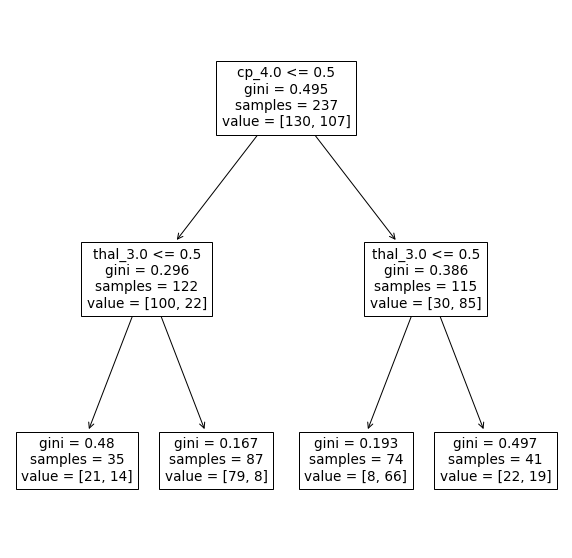

In [13]:
#We train a decision tree that only has a short depth
# The choice of parameters doesn't really matter here, apart from max_depth
dtc = DecisionTreeClassifier(random_state=0, max_depth=2, min_samples_leaf=2, min_samples_split=2)

#Fit on training data
dtc.fit(X_train, y_train)

#Visualise
f, ax = plt.subplots(figsize=(10,10))

tree.plot_tree(dtc, feature_names=df.columns, ax=ax)

From this simple classifier, we can see that we are only considering two variables (due to the 2 layers). These variables names are then printed out. Now, we can actually write out the decisions made in a model and predict a classification!

1. Start
2. Does the patient have a value for chest pain index 4 of less than 0.5
    
    (As this is the asymptomatic indicator, we are essentially asking "Is the patient having any chest pain?")
    
    According to the documentation [here](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py) we can figure out that a value less than the threshold (a "no" in this case) goes to the left
    
    
3. Next, we ask if the patient has a value for "thal" of 3.0
    
    (Similarly, as this is an indicator, and 3 is the indicator for no defect, we are asking "Does the patient have no thal defect?")
    
    Again, if this is a "no" (value of 0), we go to the left side at this node
    
    
    
4. Finally, we classify according to the results from these two questions.

As a note, we don't necessarily need for the questions asked during progression through the tree to be in the same order, or have the same cutoff. We could just as easily ask about different variables on each side!


In the "values" section at the bottom we can see the number of results from each class at each point. This isn't perfect, as we have some crossover, but is better than guessing. We can see how good this predictor is on the training and test data below:

In [14]:
##Predict against test and training data
y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

#Accuracy score for training data
print("Accuracy score for training data", accuracy_score(y_train, y_pred_train))

#Accuracy score for test data
print("Accuracy score for test data", accuracy_score(y_test, y_pred_test))

Accuracy score for training data 0.7932489451476793
Accuracy score for test data 0.6833333333333333


Not bad for only looking at 2 variables!

### Grid-Search Cross Validation

Here, we test different potential values of hyperparameters for our model, to see which performs the best on non-training data. This is done through a grid-search cross validation method, in which we specify lists of parameters to try. The model is then trained according to all possible combinations of these parameters, using most of the training data, but not all. We then test this model against the remaining training data, to see how well this model choice generalises. Finally, the best parameter choices are chosen, and the model is trained using all of our training data.

In the end, we get a trained model with the best parameters for generalising to unseen data, from the possible combinations of hyperparameters given to the grid-search.

In [15]:
#SVM Classifier object
dtc = DecisionTreeClassifier(random_state=0)

#Define the parameters that we want to test for
parameters = {"max_depth": [1,2,3,4,5,6,7,8,9,10,20,30,40],
              "min_samples_split": list(range(2,10)),
              "min_samples_leaf": list(range(1,10))}

#Define the grid-search
clf = GridSearchCV(dtc, parameters)

#Fit the model
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30,
                                       40],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]})

In [16]:
#View the best parameter for this model
clf.best_params_

{'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2}

Here, we can see that the best chosen hyperparameters are:
- max_depth = 6
- minimum samples for a leaf node = 3
- minimum samples to split out = 2


Next, we can again view the accuracy of this model (though it is not our final model yet), and see that we get a slight improvement over the less deep decision tree.

In [17]:
##Predict against test and training data
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

#Accuracy score for training data
print("Accuracy score for training data", accuracy_score(y_train, y_pred_train))

#Accuracy score for test data
print("Accuracy score for test data", accuracy_score(y_test, y_pred_test))

Accuracy score for training data 0.9324894514767933
Accuracy score for test data 0.7333333333333333


## Random Forest Training

Next, we use the model that generally performs best in this class - the Random Forest. This is related to decision trees, and as you might be able to guess by the name, is made up of many decision trees. The way that a random forest works is by taking samples of the training data (with replacement, so we could use the same sample twice), and training decision tree classifiers on this subsample. Once we have a lot of these individual decision trees, we create our overall forest classifier. In the Random Forest, we get a prediction from each decision tree (constructed from randomly sampled training data), and find the class with the most "votes". This class is then predicted for the given data-point!

There are again parameters for this model, so we will use another grid-search to train. The parameter that we add "n_estimators" defines how many individual decision trees make up our forest.


In [18]:
#Random Forest Classifier Object
dtc = RandomForestClassifier(random_state=0)

#Define the parameters that we want to test for
parameters = {"max_depth": [1,2,3,4,5,6,7,8,9,10,20],
              "min_samples_split": list(range(2,5)),
              "min_samples_leaf": list(range(1,5)),
              "n_estimators": [25,50,60,70,80,90,100,125,150]}

#Define the grid-search
clf = GridSearchCV(dtc, parameters)

#Fit the model
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [25, 50, 60, 70, 80, 90, 100, 125,
                                          150]})

In [19]:
#View the best parameter for this model
clf.best_params_

{'max_depth': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 70}

## Prediction on Test Data

Finally, we can predict against test-data to evaluate the usefulness of our model. 

### Making Predictions

In [20]:
#Predict against test and training data
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

### Testing the Accuracy of Predictions

Here, we look at the proportion of cases in both the test and training dataset that are successfully classified.

In [21]:
#Accuracy score for training data
accuracy_score(y_train, y_pred_train)

0.8649789029535865

In [22]:
#Accuracy score for test data
accuracy_score(y_test, y_pred_test)

0.8

### Confusion Matrix

Another metric that we can use to show the accuracy of the prediction is by using a confusion matrix. This shows us exactly which true labels were classified as, normalised to be a proportion of the dataset. This can be extremely useful in cases with many labels, especially when things go wrong. For example, we might end up training a model that misclassifies all plants of one species as another species. In this case, we might want to collect more variables, or build a secondary classifier to differentiate these two species from each other, after they have been separated from the rest of the data.

To do this, we first map the 0 and 1 indicators contained in our true values (`y_test`), and our predicted values (`y_pred_test`) to the labels "No Disease" and "Disease".

In [23]:
#Map the 0/1 indicators into labels
map_dict = {0: "No Disease",
            1: "Disease"}


#Create a lambda function to apply this as a convertion
index_to_label = lambda n: np.array([map_dict.get(x) for x in n])

#Use this to convert our values into labels
y_test_label = index_to_label(y_test)
y_pred_test_label = index_to_label(y_pred_test)

In [24]:
#Show that the above cell worked!
y_test_label

array(['No Disease', 'No Disease', 'Disease', 'No Disease', 'No Disease',
       'Disease', 'Disease', 'No Disease', 'Disease', 'No Disease',
       'Disease', 'No Disease', 'No Disease', 'Disease', 'Disease',
       'No Disease', 'Disease', 'No Disease', 'Disease', 'Disease',
       'Disease', 'Disease', 'No Disease', 'No Disease', 'No Disease',
       'Disease', 'Disease', 'No Disease', 'No Disease', 'No Disease',
       'Disease', 'Disease', 'Disease', 'Disease', 'No Disease',
       'Disease', 'No Disease', 'Disease', 'Disease', 'No Disease',
       'No Disease', 'Disease', 'Disease', 'No Disease', 'No Disease',
       'Disease', 'Disease', 'No Disease', 'No Disease', 'No Disease',
       'Disease', 'Disease', 'Disease', 'No Disease', 'Disease',
       'Disease', 'No Disease', 'No Disease', 'No Disease', 'No Disease'],
      dtype='<U10')

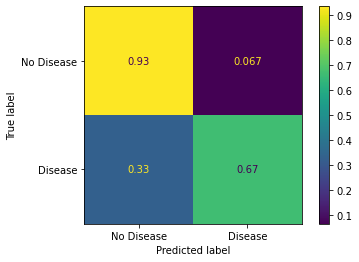

In [25]:
labels = ["No Disease", "Disease"]

#Generate the confusion matrix
cm = confusion_matrix(y_test_label, y_pred_test_label, labels = labels, normalize= 'true')

#Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

As we can see in this confusion matrix, our model is generally better when predicting cases of non-heart disease. The performance of this model isn't the best ever, but with more variables or different methods we can get better performance. Even with it as it is right now though, we could think about using it as a pre-check to see if the patient might require a further examination.